## Introduction to Missing Data Diagnostics and Treatment

### Speaker: Ricardo J. Serrano

### Objectives

*  What is missing data?

*  Missing data mechanisms (MCAR, MAR, MNAR)

*  How to treat missing data the right way

### What is missing data/values?

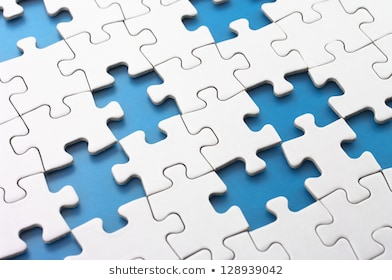

### Missing Data Mechanisms

*  Missing Completely at Random (MCAR)

*  Missing at Random (MAR)

*  Missing Not at Random (MNAR)

Source: Rubin (1976)

### Missing Completely at Random (MCAR)

*  Locations of missing values in the dataset are purely random, they do not depend on any other data.

*  Example: A weather sensor is measuring temperature and sending the data to a database. There are some missing entries in the database for when the sensor broke down.

### Missing at Random (MAR)

*  Locations of missing values in the dataset depend on some other, observed data.

*  There are some missing temperature values in the database for when the sensor was switched off for maintenance. As the maintenance team never work on the weekends, the locations of missing values depend on the day of the week.

### Missing Not at Random (MNAR)

*  Locations of missing values in the dataset depend on the missing values themselves.

*  When it's extremely cold, the weather sensor freezes and stops working. So, it does not record very low temperatures. Thus, the locations of missing values in the temperature variable depend on the values of this variable themselves.

### Why detecting the missing data mechanism is important?

*  Imputation methods make assumptions on the type of missing data mechanism.

*  Justifies the strategy to deal with missing data.

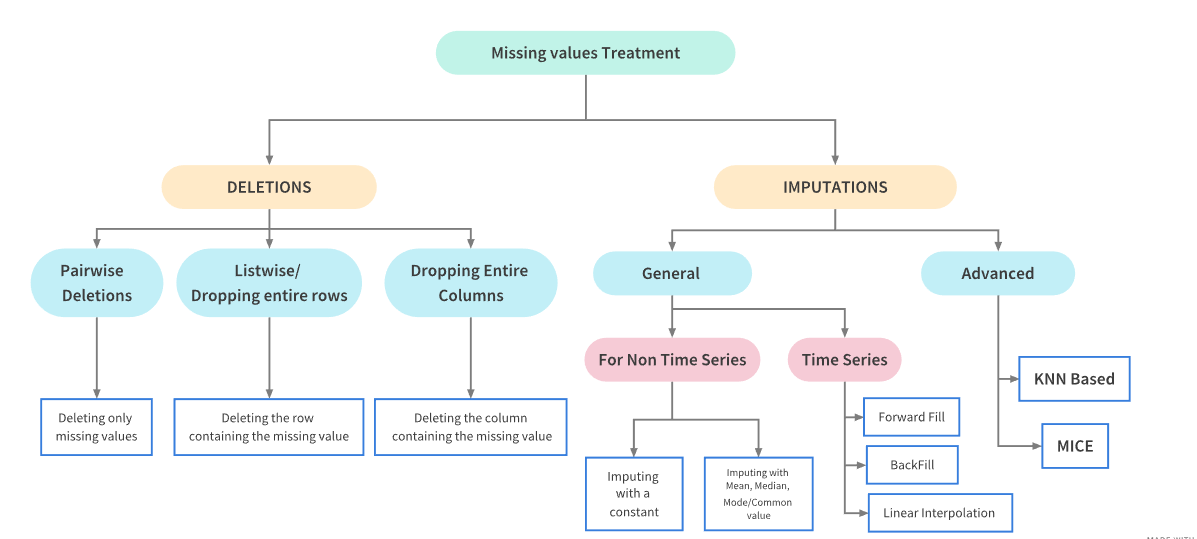

### How can the missing data mechanisms be detected?

*  Data visualization

*  Statistical tests (MCAR)

In [28]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas_profiling import profile_report, ProfileReport

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# supress warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,10)

## PIMA Natives Diabetes Dataset

The Pima Natives Diabetes Dataset involves predicting the onset of diabetes within 5 years in Pima Natives given medical details.

There are 768 observations with 8 input variables and 1 output variable. The variable names are as follows:

0. Number of times pregnant.

1. Plasma glucose concentration a 2 hours in an oral glucose tolerance test.

2. Diastolic blood pressure (mm Hg).

3. Triceps skinfold thickness (mm).

4. 2-Hour serum insulin (mu U/ml).

5. Body mass index (weight in kg/(height in m)^2).

6. Diabetes pedigree function.

7. Age (years).

8. Class variable (0 or 1).

In [2]:
# read the PIMA dataset
data_web_address = "https://raw.githubusercontent.com/LamaHamadeh/Pima-Indians-Diabetes-DataSet-UCI/master/pima_indians_diabetes.txt"

column_names = ['pregnancies', 
                'glucose', 
                'blood_pressure', 
                'skin_thickness', 
                'insulin', 
                'bmi', 
                'diabetes_pedigree_func', 
                'age', 
                'target']

feature_names = column_names[:-1]
df = pd.read_csv(data_web_address , names=column_names)
df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_func,age,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pregnancies             768 non-null    int64  
 1   glucose                 768 non-null    int64  
 2   blood_pressure          768 non-null    int64  
 3   skin_thickness          768 non-null    int64  
 4   insulin                 768 non-null    int64  
 5   bmi                     768 non-null    float64
 6   diabetes_pedigree_func  768 non-null    float64
 7   age                     768 non-null    int64  
 8   target                  768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
blood_pressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skin_thickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
bmi,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
diabetes_pedigree_func,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
target,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [6]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
# verify missing values
missing_values_table(df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### **No missing values (???)**

But I thought we were going to talk about how to handle missing values, right?

### Ok, let's take a closer look at the dataset features.

Do you notice something odd at some of the features quantities (ex. blood pressure)?

In [8]:
# Let's examine the zeros on each features
(df == 0).sum()

pregnancies               111
glucose                     5
blood_pressure             35
skin_thickness            227
insulin                   374
bmi                        11
diabetes_pedigree_func      0
age                         0
target                    500
dtype: int64

## Some features with zeros represent missing values (NaNs) !!

In [9]:
# let's substitute those zeros to NaNs for selected columns
cols_selected = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']

df[cols_selected] = df[cols_selected].replace(0, np.NaN)

In [10]:
df.head(10)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_func,age,target
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8,125.0,96.0,NaN,NaN,NaN,0.232,54,1


In [11]:
# verify missing values
missing_values_table(df)

Your selected dataframe has 9 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
insulin,374,48.7
skin_thickness,227,29.6
blood_pressure,35,4.6
bmi,11,1.4
glucose,5,0.7


In [12]:
# pandas profiling
# profile = df.profile_report(title = 'PIMA Indians Diabetes Dataset Profile')

# profile.to_file('pima_diabetes.html')

### Decision time

Should we delete the features or observations with missing values or impute them?

## Experiment 1 - Remove rows/observations with missing values

In [13]:
df_copy = df.copy()

In [14]:
# remove rows with NaNs
df_remove_rows = df.dropna()

In [15]:
df_remove_rows.shape

(392, 9)

In [16]:
# define function to run logistic regression cross validation score accuracy
def model_fit(dataset):
    values = dataset.values
    X = values[:,1:8]
    Y = values[:,8]
    logreg = LogisticRegression()
    kfold = KFold(n_splits=3)
    result = cross_val_score(logreg, X, Y, cv = kfold, scoring="accuracy")
    print("Logistic Regression (accuracy):", result.mean().round(3))

In [17]:
model_fit(df_remove_rows)

Logistic Regression (accuracy): 0.788


## Experiment 2 - Impute missing values with median

In [18]:
# impute missing values with median
df_impute_median = df.fillna(df.median())

In [19]:
df_impute_median.head(10)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_func,age,target
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,29.0,125.0,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,72.0,29.0,125.0,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8,125.0,96.0,29.0,125.0,32.3,0.232,54,1


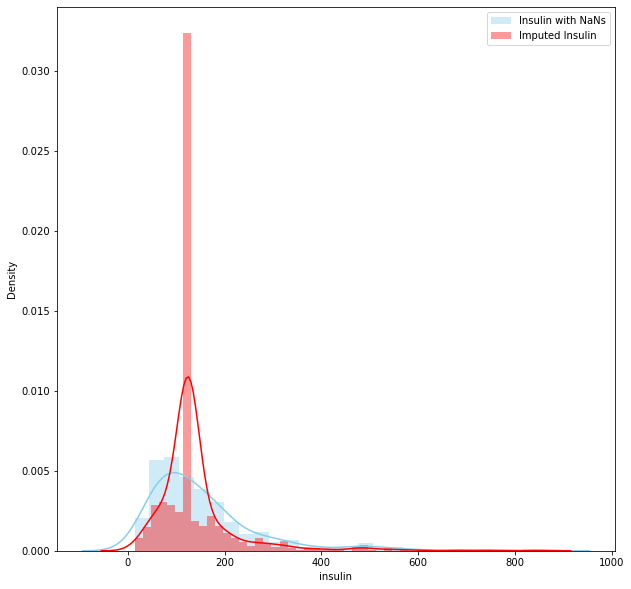

In [29]:
# distplot for `insulin` before and after the imputation
sns.distplot(df['insulin'] , color="skyblue", label='Insulin with NaNs')
sns.distplot(df_impute_median['insulin'] , color="red", label='Imputed Insulin')
plt.legend()

In [30]:
model_fit(df_impute_median)

Logistic Regression (accuracy): 0.768


## Experiment 3 - Impute missing values with sklearn IterativeImputer (mice)

In [22]:
# instatiate IterativeImputer()
imp = IterativeImputer(estimator = ExtraTreesRegressor(n_jobs = -1), max_iter = 100, random_state = 42)

In [23]:
df_impute_iterative = df.drop('target', axis = 1)

In [24]:
df_impute_iterative

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_func,age
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47


In [25]:
# impute missing values
imp.fit(df_impute_iterative)

df_imp = pd.DataFrame(imp.transform(df_impute_iterative), columns = df_impute_iterative.columns)

In [26]:
df_imp

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_func,age
0,6.0,148.0,72.0,35.00,205.53,33.6,0.627,50.0
1,1.0,85.0,66.0,29.00,61.26,26.6,0.351,31.0
2,8.0,183.0,64.0,20.14,231.55,23.3,0.672,32.0
3,1.0,89.0,66.0,23.00,94.00,28.1,0.167,21.0
4,0.0,137.0,40.0,35.00,168.00,43.1,2.288,33.0
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.00,180.00,32.9,0.171,63.0
764,2.0,122.0,70.0,27.00,160.26,36.8,0.340,27.0
765,5.0,121.0,72.0,23.00,112.00,26.2,0.245,30.0
766,1.0,126.0,60.0,28.42,146.72,30.1,0.349,47.0


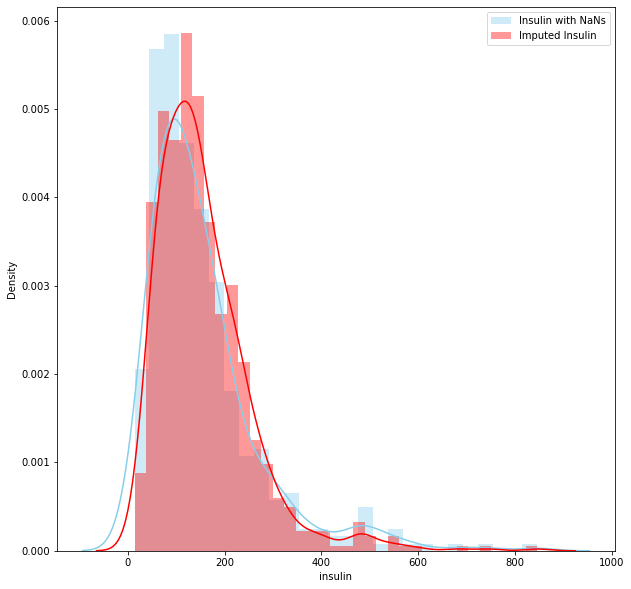

In [31]:
# distplot for `insulin` before and after the imputation
sns.distplot(df['insulin'] , color="skyblue", label='Insulin with NaNs')
sns.distplot(df_imp['insulin'] , color="red", label='Imputed Insulin')
plt.legend()

In [32]:
# add 'target' to df_imp
df_imp['target'] = df['target']
df_imp

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_func,age,target
0,6.0,148.0,72.0,35.00,205.53,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.00,61.26,26.6,0.351,31.0,0
2,8.0,183.0,64.0,20.14,231.55,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.00,94.00,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.00,168.00,43.1,2.288,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.00,180.00,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.00,160.26,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.00,112.00,26.2,0.245,30.0,0
766,1.0,126.0,60.0,28.42,146.72,30.1,0.349,47.0,1


In [33]:
model_fit(df_imp)

Logistic Regression (accuracy): 0.767


## Conclusions

1. MCAR, MAR, MNAR

2. Delete/impute (there is a third alternative)

3. Check zeroes/-1/999 in the dataset (they could be missing values)

4. Read the dataset documentation

5. Be careful when using mean/median/mode imputation (they alter the original distribution variance)